# Développez un programme d'IA pour la prédiction des faillites d'entreprises  

## Partie model

### Importation des librairies

In [30]:
#!pip install imblearn

In [54]:
import pandas as pd
import numpy as np

#viz
import matplotlib.pyplot as plt
import seaborn as sns

#imblearn, SMOTE
import imblearn
from imblearn.over_sampling import SMOTE

import sklearn
from sklearn.preprocessing import StandardScaler , RobustScaler, MinMaxScaler
#classe pour l'ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

#Model évaluation / ensemble models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

#eval
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.inspection import permutation_importance

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    confusion_matrix, classification_report

# Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.svm import SVC

# Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn import set_config; set_config(display='diagram')

import warnings
warnings.filterwarnings("ignore")

### Sommaire

[Pipeline](#chapter1)  
[Testing model](#chapter2)  
[Result model](#chapter3)  
[Evalution model](#chapter4)  
[GridSearchcv](#chapter5)  

In [32]:
df = pd.read_csv('data/dataset_nopca.csv')

## Pipeline <a class="anchor" id="chapter1"></a>

In [87]:
# Create a pipeline
bagging_pipeline = imbpipeline([
    ("balancing", SMOTE(random_state=1)),
    ("scaling", RobustScaler()),
    ("classifier", RandomForestClassifier(max_depth=10, n_estimators=400, random_state=100))
])

bagging_pipeline

Pipeline(steps=[('balancing', SMOTE(random_state=1)),
                ('scaling', RobustScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=400,
                                        random_state=100))])

## Testing model <a class="anchor" id="chapter2"></a>

In [88]:
y= df['Bankrupt?_y']
X= df.drop('Bankrupt?_y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size= 0.3,
                                                    random_state=0)

pipe_training = bagging_pipeline.fit(X_train, y_train)

y_pred = pipe_training.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1987
           1       0.25      0.54      0.34        59

    accuracy                           0.94      2046
   macro avg       0.62      0.75      0.66      2046
weighted avg       0.96      0.94      0.95      2046



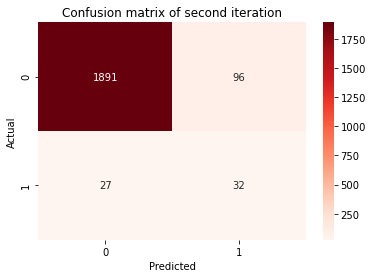

In [89]:
conf_mat_2 = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat_2, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion matrix of second iteration")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Result model <a class="anchor" id="chapter3"></a>

BaggingClassifier(max_samples=0.1, n_estimators=3)  
score recall = 0.56  

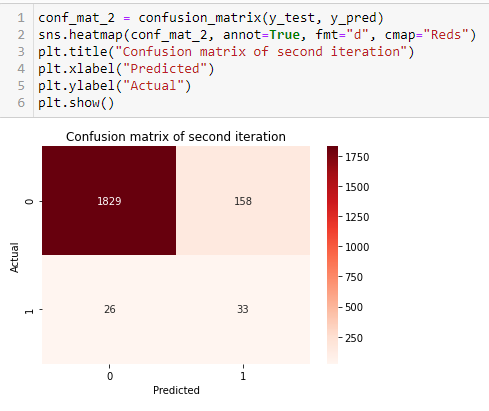

RandomForestClassifier(max_depth=10, n_estimators=400, random_state=100)

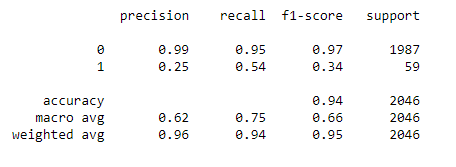

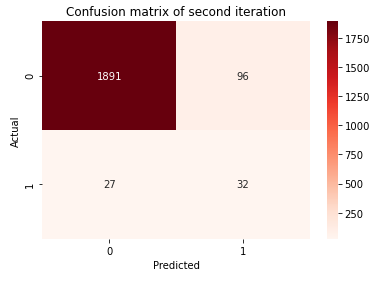

## Evalution Model <a class="anchor" id="chapter4"></a>

In [9]:
model_1 = SGDClassifier(random_state=0)
model_2 = DecisionTreeClassifier(random_state=0)
model_3 = KNeighborsClassifier(n_neighbors=2)
model_4 = RandomForestClassifier(n_estimators=100)
model_5 = GradientBoostingClassifier(n_estimators=100)

model_6 = VotingClassifier([('SGD', model_1),
                           ('Tree', model_2),
                           ('KNN', model_3),
                            ('Forest', model_4),
                           ('GBC', model_5)],
                           voting='hard')


for model in (model_1, model_2, model_3, model_4, model_5, model_6):
    model.fit(X_train, y_train)
    result_tmp = model.predict(X_test)
    print(classification_report(y_test,result_tmp))
    print(model.__class__.__name__, model.score(X_test, y_test))
    print("----------------------------------------------------")
    print("----------------------------------------------------")

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1987
           1       0.24      0.34      0.28        59

    accuracy                           0.95      2046
   macro avg       0.61      0.65      0.63      2046
weighted avg       0.96      0.95      0.95      2046

SGDClassifier 0.9501466275659824
----------------------------------------------------
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1987
           1       0.21      0.27      0.24        59

    accuracy                           0.95      2046
   macro avg       0.59      0.62      0.61      2046
weighted avg       0.96      0.95      0.95      2046

DecisionTreeClassifier 0.9496578690127078
----------------------------------------------------
----------------------------------------------------
              precision    recall  f1-score   support

    

In [10]:
model_7 = BaggingClassifier(base_estimator=KNeighborsClassifier(),
                         n_estimators=100)

model_7.fit(X_train, y_train)
model_7.score(X_test, y_test)
result_tmp_ = model_7.predict(X_test)
print(classification_report(y_test,result_tmp_))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1987
           1       0.46      0.19      0.27        59

    accuracy                           0.97      2046
   macro avg       0.72      0.59      0.62      2046
weighted avg       0.96      0.97      0.96      2046



In [11]:
model_8 = StackingClassifier([('SGD', model_1),
                              ('Tree', model_2),
                              ('KNN', model_3),
                              ('Forest', model_4),
                              ('GBC', model_5),
                             ('BaggCla', model_7)],
                             final_estimator=KNeighborsClassifier())


model_8.fit(X_train, y_train)
model_8.score(X_test, y_test)
result_tmp_ = model_8.predict(X_test)
print(classification_report(y_test,result_tmp_))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1987
           1       0.36      0.29      0.32        59

    accuracy                           0.96      2046
   macro avg       0.67      0.64      0.65      2046
weighted avg       0.96      0.96      0.96      2046



## GridSearchcv <a class="anchor" id="chapter5"></a>

In [67]:
# #BaggingClassifier
# param_grid = {
#     'classifier__n_estimators' : [1, 2, 3, 4, 5],
#     'classifier__max_samples' : [0.05, 0.1, 0.2, 0.5]
# }

In [78]:
#search key for params
rnd_search = GridSearchCV(bagging_pipeline, param_grid= param_grid)

In [79]:
for param in rnd_search.get_params().keys():
    print(param)

cv
error_score
estimator__memory
estimator__steps
estimator__verbose
estimator__balancing
estimator__scaling
estimator__classifier
estimator__balancing__k_neighbors
estimator__balancing__n_jobs
estimator__balancing__random_state
estimator__balancing__sampling_strategy
estimator__scaling__copy
estimator__scaling__quantile_range
estimator__scaling__unit_variance
estimator__scaling__with_centering
estimator__scaling__with_scaling
estimator__classifier__bootstrap
estimator__classifier__ccp_alpha
estimator__classifier__class_weight
estimator__classifier__criterion
estimator__classifier__max_depth
estimator__classifier__max_features
estimator__classifier__max_leaf_nodes
estimator__classifier__max_samples
estimator__classifier__min_impurity_decrease
estimator__classifier__min_impurity_split
estimator__classifier__min_samples_leaf
estimator__classifier__min_samples_split
estimator__classifier__min_weight_fraction_leaf
estimator__classifier__n_estimators
estimator__classifier__n_jobs
estimator_

In [84]:
param_grid = {
    'classifier__n_estimators' : [200, 400],
    'classifier__random_state' : [100, 200],
    'classifier__max_features': ['auto', 'sqrt'],
    'classifier__bootstrap' : [True, False],
    'classifier__max_depth' : [10, 20, None]
}

In [85]:
#search best param for model
clf = GridSearchCV(estimator= bagging_pipeline,
                   param_grid= param_grid,
                   scoring ='recall',
                   return_train_score=True,
                   verbose=3)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=auto, classifier__n_estimators=200, classifier__random_state=100; total time=   7.6s
[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=auto, classifier__n_estimators=200, classifier__random_state=100; total time=   7.7s
[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=auto, classifier__n_estimators=200, classifier__random_state=100; total time=   8.0s
[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=auto, classifier__n_estimators=200, classifier__random_state=100; total time=   8.5s
[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=auto, classifier__n_estimators=200, classifier__random_state=100; total time=   8.0s
[CV 1/5] END classifier__bootstrap=True, classifier__

[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=auto, classifier__n_estimators=200, classifier__random_state=200; total time=  10.3s
[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=auto, classifier__n_estimators=200, classifier__random_state=200; total time=  10.3s
[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=auto, classifier__n_estimators=200, classifier__random_state=200; total time=  10.0s
[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=auto, classifier__n_estimators=200, classifier__random_state=200; total time=  10.6s
[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=auto, classifier__n_estimators=400, classifier__random_state=100; total time=  21.0s
[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=auto, classifier__n_est

[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=auto, classifier__n_estimators=400, classifier__random_state=100; total time=  21.3s
[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=auto, classifier__n_estimators=400, classifier__random_state=100; total time=  21.4s
[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=auto, classifier__n_estimators=400, classifier__random_state=200; total time=  23.0s
[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=auto, classifier__n_estimators=400, classifier__random_state=200; total time=  22.7s
[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=auto, classifier__n_estimators=400, classifier__random_state=200; total time=  23.0s
[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=auto, class

[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=auto, classifier__n_estimators=400, classifier__random_state=200; total time=  24.6s
[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=200, classifier__random_state=100; total time=  12.3s
[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=200, classifier__random_state=100; total time=  12.2s
[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=200, classifier__random_state=100; total time=  11.7s
[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=200, classifier__random_state=100; total time=  11.7s
[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=sqrt, classifier_

[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=sqrt, classifier__n_estimators=200, classifier__random_state=200; total time=  17.7s
[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=sqrt, classifier__n_estimators=200, classifier__random_state=200; total time=  16.8s
[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=sqrt, classifier__n_estimators=200, classifier__random_state=200; total time=  17.4s
[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=sqrt, classifier__n_estimators=200, classifier__random_state=200; total time=  17.8s
[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=sqrt, classifier__n_estimators=400, classifier__random_state=100; total time=  36.2s
[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=sqrt, classifier_

[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=None, classifier__max_features=sqrt, classifier__n_estimators=400, classifier__random_state=100; total time=  45.1s
[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=None, classifier__max_features=sqrt, classifier__n_estimators=400, classifier__random_state=100; total time=  42.9s
[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=None, classifier__max_features=sqrt, classifier__n_estimators=400, classifier__random_state=100; total time=  43.6s
[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=None, classifier__max_features=sqrt, classifier__n_estimators=400, classifier__random_state=200; total time=  47.3s
[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=None, classifier__max_features=sqrt, classifier__n_estimators=400, classifier__random_state=200; total time=  47.5s
[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=None, classifier__max_features=sqrt,

GridSearchCV(estimator=Pipeline(steps=[('balancing', SMOTE(random_state=1)),
                                       ('scaling', RobustScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__max_depth': [10, 20, None],
                         'classifier__max_features': ['auto', 'sqrt'],
                         'classifier__n_estimators': [200, 400],
                         'classifier__random_state': [100, 200]},
             return_train_score=True, scoring='recall', verbose=3)

In [86]:
best_estim= clf.best_estimator_
print(best_estim)

Pipeline(steps=[('balancing', SMOTE(random_state=1)),
                ('scaling', RobustScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=400,
                                        random_state=100))])


In [ ]:
# print("Best Estimator: \n{}\n".format(gs.best_estimator_))
# print("Best Parameters: \n{}\n".format(gs.best_params_))
# print("Best Test Score: \n{}\n".format(gs.best_score_))
# print("Best Training Score: \n{}\n".format(gs.cv_results_['mean_train_score'][gs.best_index_]))
# print("All Training Scores: \n{}\n".format(gs.cv_results_['mean_train_score']))
# print("All Test Scores: \n{}\n".format(gs.cv_results_['mean_test_score']))
# # # This prints out all results during Cross-Validation in details
# #print("All Meta Results During CV Search: \n{}\n".format(gs.cv_results_))